In [1]:
import sys

import numpy as np

sys.path.append("/home/cyprien/Documents/github/pytorch-forecasting")

import hashlib

from data_factory.preprocessing import *
from utilities.config import load_config

from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

logging.basicConfig(level=DEBUG)
logger = logging.getLogger(__name__)
logger.setLevel(DEBUG)

In [2]:
config_file = '../config/config.yml'
use_previous_files = False
export = False

In [3]:
config = load_config(config_file)

model = config['model']
model_config = config[model]

# Create variables from config
#  data loading
save_folder = config['data']['save']
train_file = config['data']['train_path'] + config['data']['stock_prices']
test_file = config['data']['test_path'] + config['data']['stock_prices']

#  TimeSeries settings
max_prediction_length = model_config['sliding_window']['max_prediction_length']
min_prediction_length = model_config['sliding_window']['min_prediction_length']
max_encoder_length = model_config['sliding_window']['max_encoder_length']
min_encoder_length = model_config['sliding_window']['min_encoder_length']
batch_size = model_config['sliding_window']['batch_size']

related_stocks = model_config['related_stock']
train_val_split = model_config['train_val_split']
scale = model_config['manual_scale']

# define file name for saving StockPricesLoader with specific config
hash_ = hashlib.md5(model_config.__str__().encode('utf-8')).hexdigest()
export_file_name = f"{save_folder}/export_{hash_}.p"
logger.debug(f'Export file {export_file_name}')

logger.debug(f'Use config {config}')


DEBUG:__main__:Export file ../data/save//export_afebfaf4d51991e869bdb4e9c9e73e70.p
DEBUG:__main__:Use config {'device': 'cpu', 'seed': False, 'model': 'temporal_fusion_transformer', 'data': {'save': '../data/save/', 'suppl': '../data/suppl/', 'train_path': '../data/jpx-tokyo-stock-exchange-prediction/train_files/', 'test_path': '../data/jpx-tokyo-stock-exchange-prediction/supplemental_files/', 'financials': 'financials.csv', 'stock_prices': 'stock_prices.csv', 'options': 'options.csv', 'secondary_stock_price': 'secondary_stock_prices.csv', 'trades': 'trades.csv', 'cosine': 'cosine_df.csv'}, 'rnn': {'sliding_window': {'max_prediction_length': 10, 'min_prediction_length': 10, 'max_encoder_length': 150, 'min_encoder_length': 150, 'batch_size': 64}, 'train_val_split': 1, 'related_stock': 2, 'manual_scale': True, 'hidden_size': 20, 'layers': 3, 'dropout': 0}, 'temporal_fusion_transformer': {'sliding_window': {'max_prediction_length': 5, 'min_prediction_length': 5, 'max_encoder_length': 150,

### Load

In [4]:
from data_factory.prepared_data import PreparedData

data: PreparedData = PreparedData.from_file("../data/save/preprocessed_data.pkl")
df_train = data.train
df_val = data.val
df_test = data.test

## Data Augmentation

#### Add related stocks

In [5]:
n = related_stocks

cosine = pd.read_csv(config['data']['suppl'] + config['data']['cosine'], low_memory=False).rename(columns={'Unnamed: 0': 'ticker'})

cosine.set_index('ticker', inplace=True)
top = cosine.apply(lambda s: pd.Series(s.nlargest(related_stocks).index)).T.astype(str).rename(columns=str)
missing_keys = list(set(df_train.SecuritiesCode.unique()) - set(cosine.columns))
logger.info(f"Len missing Securities Code in {config['data']['cosine']}: {len(missing_keys)}")

top = pd.concat([top, pd.DataFrame({str(i): missing_keys for i in range(n)}, index=missing_keys)])

def add_stocks(df: pd.DataFrame):
    for t, col in tqdm([(f'top_{i}', str(i)) for i in range(n)]):
        df[t] = df.SecuritiesCode.transform(lambda x: top.loc[x, col])

        df = df.merge(
            df.loc[:, ['SecuritiesCode', 'Timestamp', 'Close', 'Close_scaled']],
            how='left', left_on=[t, 'Timestamp'], right_on=['SecuritiesCode', 'Timestamp'],
            suffixes=('', f'_{t}')
        ).drop(columns=f'SecuritiesCode_{t}')

        # FIXME
        df[f'Close_scaled_{t}'] = df.groupby('SecuritiesCode')[f'Close_scaled_{t}'].apply(lambda x: pd.Series(np.zeros_like(x.to_numpy())) if x.isna().sum() != 0 else x).reset_index(drop=True)
        df[f'Close_{t}'] = df.groupby('SecuritiesCode')[f'Close_{t}'].apply(lambda x: pd.Series(np.zeros_like(x.to_numpy())) if x.isna().sum() != 0 else x).reset_index(drop=True)

    return df

df_train = add_stocks(df_train)
df_test = add_stocks(df_test)
df_val = add_stocks(df_val)

INFO:__main__:Len missing Securities Code in cosine_df.csv: 0
100%|██████████| 5/5 [00:25<00:00,  5.16s/it]


DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/cyprien/anaconda3/envs/pytorch/lib/py

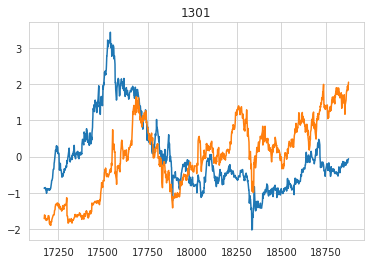

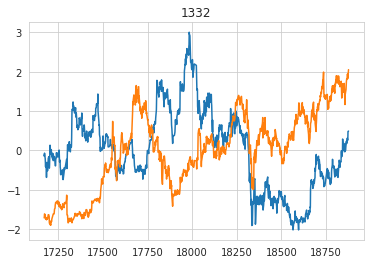

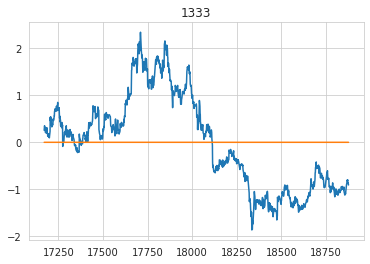

In [6]:
for sc in df_train.SecuritiesCode.unique()[:3]:
    plt.plot(df_train.loc[df_train.SecuritiesCode == sc, 'Timestamp'], df_train.loc[df_train.SecuritiesCode == sc, 'Close_scaled'])
    plt.plot(df_train.loc[df_train.SecuritiesCode == sc, 'Timestamp'], df_train.loc[df_train.SecuritiesCode == sc, 'Close_scaled_top_0'])
    plt.title(sc)
    plt.show()

cosine_1 -> domain
cosine_2 -> financial report
cosine_3 -> other

top 5

sector -> [1301, 1392, 6723] (agriculture) ...  (679, 678, ) (bank group)

1301  group_sector 1
679  group_sector 2


financial report -> [1301, 1392, 6723] (bad / good) ...



### Moving average

ValueError: x and y must have same first dimension, but have shapes (50,) and (1142,)

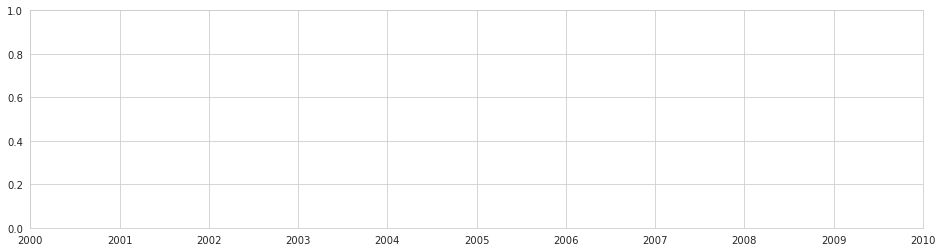

In [28]:
spans = [200, 100, 50, 10, 5, 4, 3, 2]
alphas = []
example_sc = '9990'

def moving_average(df):
    plt.figure(figsize=(16, 4))
    plt.plot(df[df.SecuritiesCode == example_sc].Date.iloc[:50], df[df.SecuritiesCode == example_sc].Close_scaled)
    for span in spans:
        df[f'Close_scaled_ewm_{span}'] = df.groupby('SecuritiesCode').Close_scaled.ewm(span=span).mean().reset_index(drop=True)
        plt.plot(df[df.SecuritiesCode == example_sc].Date.iloc[:50],
                 df[df.SecuritiesCode == example_sc][f'Close_scaled_ewm_{span}'].iloc[:50], label=f'Close_scaled_ewm_{span}')
    plt.legend()
    return df

df_train = moving_average(df_train)
df_test = moving_average(df_test)
df_val = moving_average(df_val)

Cross point

### Add differences

In [8]:
from itertools import product

cols = ['Close_scaled', 'High_scaled', 'Low_scaled'] + [f'Close_scaled_ewm_{i}' for i in spans]
diffs = [1, 2, 3, 4, 5, 10, 30]

def differences(df: pd.DataFrame):
    for col, diff in product(cols, diffs):
        df[f'{col}_diff_d{diff}'] = df[col].diff(diff).fillna(0)
    return df

df_train = differences(df_train)
df_test = differences(df_test)
df_val = differences(df_val)

### Day of week

In [9]:
df_train['dayofweek'] = df_train.Date.dt.dayofweek.astype(str)
df_test['dayofweek'] = df_test.Date.dt.dayofweek.astype(str)
df_val['dayofweek'] = df_val.Date.dt.dayofweek.astype(str)

### Export

In [10]:
data = PreparedData(df_train, df_val, df_test, data.scalers)

In [11]:
data.export('../data/save/augmented_data.pkl')

#### Experiments

##### secondary stock prices


In [12]:


scp = pd.read_csv(config['data']['train_path'] + config['data']['secondary_stock_price'])
scp.head(2)


scp.shape, scp.SecuritiesCode.unique().size, len(set(scp.SecuritiesCode.unique()) - set(df_train.SecuritiesCode.unique()))



((2384575, 12), 2371, 2371)

##### trades

In [13]:
trades = pd.read_csv(config['data']['train_path'] + config['data']['trades'], parse_dates=['Date', 'StartDate', 'EndDate'])
trades.head(2)

,Date,StartDate,EndDate,Section,TotalSales,TotalPurchases,TotalTotal,TotalBalance,ProprietarySales,ProprietaryPurchases,...,CityBKsRegionalBKsEtcTotal,CityBKsRegionalBKsEtcBalance,TrustBanksSales,TrustBanksPurchases,TrustBanksTotal,TrustBanksBalance,OtherFinancialInstitutionsSales,OtherFinancialInstitutionsPurchases,OtherFinancialInstitutionsTotal,OtherFinancialInstitutionsBalance
0,2017-01-04,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-05,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
(trades.EndDate - trades.StartDate)[(trades.EndDate - trades.StartDate).notna()].value_counts()

4 days    633
3 days     96
2 days     15
1 days     15
0 days      6
dtype: int64

In [15]:
(trades.Date - trades.StartDate)[(trades.EndDate - trades.StartDate).notna()].value_counts()

10 days    600
9 days      87
11 days     24
15 days     15
14 days     15
7 days       9
16 days      6
8 days       6
18 days      3
dtype: int64

In [16]:
trades.shape, trades.columns

((1712, 56),
 Index(['Date', 'StartDate', 'EndDate', 'Section', 'TotalSales',
        'TotalPurchases', 'TotalTotal', 'TotalBalance', 'ProprietarySales',
        'ProprietaryPurchases', 'ProprietaryTotal', 'ProprietaryBalance',
        'BrokerageSales', 'BrokeragePurchases', 'BrokerageTotal',
        'BrokerageBalance', 'IndividualsSales', 'IndividualsPurchases',
        'IndividualsTotal', 'IndividualsBalance', 'ForeignersSales',
        'ForeignersPurchases', 'ForeignersTotal', 'ForeignersBalance',
        'SecuritiesCosSales', 'SecuritiesCosPurchases', 'SecuritiesCosTotal',
        'SecuritiesCosBalance', 'InvestmentTrustsSales',
        'InvestmentTrustsPurchases', 'InvestmentTrustsTotal',
        'InvestmentTrustsBalance', 'BusinessCosSales', 'BusinessCosPurchases',
        'BusinessCosTotal', 'BusinessCosBalance', 'OtherInstitutionsSales',
        'OtherInstitutionsPurchases', 'OtherInstitutionsTotal',
        'OtherInstitutionsBalance', 'InsuranceCosSales',
        'InsuranceCos

In [17]:
trades.Section.value_counts(), trades.Section.isnull().sum()

(Growth Market (Mothers/JASDAQ)      255
 Prime Market (First Section)        255
 Standard Market (Second Section)    255
 Name: Section, dtype: int64,
 947)

In [18]:
trades.columns[pd.Series(trades.columns).str.contains('Date')]

Index(['Date', 'StartDate', 'EndDate'], dtype='object')

<AxesSubplot:xlabel='Date', ylabel='TotalSales'>

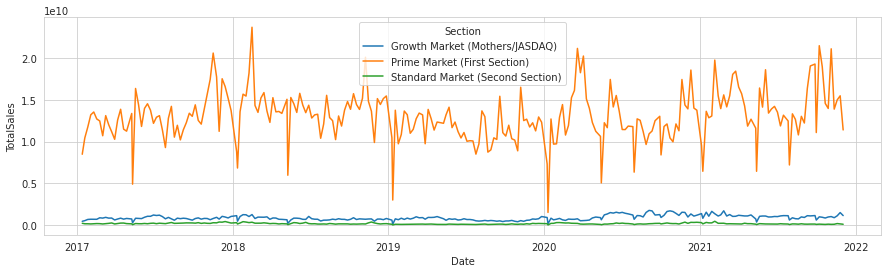

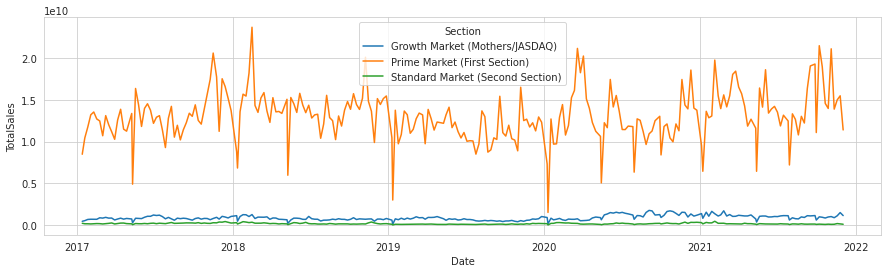

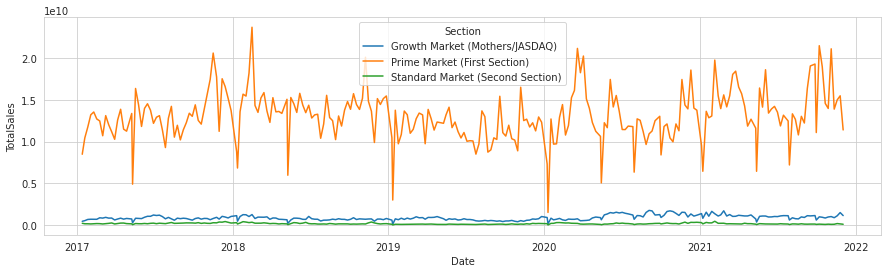

In [19]:
import seaborn as sns
sns.set_style("whitegrid")

figure = plt.figure(figsize=(15, 4))
sns.lineplot(x='Date', y='TotalSales', hue='Section', data=trades, figure=figure)

figure = plt.figure(figsize=(15, 4))
sns.lineplot(x='Date', y='TotalSales', hue='Section', data=trades, figure=figure)

figure = plt.figure(figsize=(15, 4))
sns.lineplot(x='Date', y='TotalSales', hue='Section', data=trades, figure=figure)


##### options

In [20]:
options = pd.read_csv(config['data']['train_path'] + config['data']['options'], parse_dates=['Date', 'LastTradingDay', 'SpecialQuotationDay'])
options.shape


/tmp/ipykernel_741500/1942791827.py:1: DtypeWarning: Columns (7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  options = pd.read_csv(config['data']['train_path'] + config['data']['options'], parse_dates=['Date', 'LastTradingDay', 'SpecialQuotationDay'])


(3567694, 31)

In [21]:
options.columns

Index(['DateCode', 'Date', 'OptionsCode', 'WholeDayOpen', 'WholeDayHigh',
       'WholeDayLow', 'WholeDayClose', 'NightSessionOpen', 'NightSessionHigh',
       'NightSessionLow', 'NightSessionClose', 'DaySessionOpen',
       'DaySessionHigh', 'DaySessionLow', 'DaySessionClose', 'TradingVolume',
       'OpenInterest', 'TradingValue', 'ContractMonth', 'StrikePrice',
       'WholeDayVolume', 'Putcall', 'LastTradingDay', 'SpecialQuotationDay',
       'SettlementPrice', 'TheoreticalPrice', 'BaseVolatility',
       'ImpliedVolatility', 'InterestRate', 'DividendRate', 'Dividend'],
      dtype='object')

In [22]:
options.OptionsCode.astype(str).str[1].value_counts()

3    1249551
4    1249551
8     534296
9     534296
Name: OptionsCode, dtype: int64

In [23]:
options.OptionsCode.astype(str).str[2:5].value_counts()

612    154760
606    150456
512    135364
706    129526
712    125848
        ...  
614        84
414        52
415        46
936        46
515        12
Name: OptionsCode, Length: 122, dtype: int64

In [24]:
options.OptionsCode.astype(str).str[7:9].value_counts()

18    3567694
Name: OptionsCode, dtype: int64

In [25]:
options[['Date', 'LastTradingDay', 'SpecialQuotationDay', 'OptionsCode']]

,Date,LastTradingDay,SpecialQuotationDay,OptionsCode
0,2017-01-04,2017-01-12,2017-01-13,132010018
1,2017-01-04,2017-01-12,2017-01-13,132010118
2,2017-01-04,2017-01-12,2017-01-13,132010218
3,2017-01-04,2017-01-12,2017-01-13,132010318
4,2017-01-04,2017-01-12,2017-01-13,132010518
...,...,...,...,...
3567689,2021-12-03,2024-12-12,2024-12-13,199244018
3567690,2021-12-03,2024-12-12,2024-12-13,199245018
3567691,2021-12-03,2024-12-12,2024-12-13,199246018
3567692,2021-12-03,2024-12-12,2024-12-13,199247018
